# Intro
Hello! This rather quick and dirty kernel shows how to get started on segmenting nuclei using a neural network in Keras. 

The architecture used is the so-called [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this. I believe they also have a tendency to work quite well even on small datasets.

Let's get started importing everything we need!

In [1]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from scipy import ndimage as ndi

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = '/home/peter/dataset/stage1_train/'
TEST_PATH = '/home/peter/dataset/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

/home/peter/anaconda3/envs/dnn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

In [3]:
from skimage.draw import circle
import math

# Get and resize train images and masks
X_train = []
Y_train = [] 

print('Getting train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    X_train.append(img)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    mark = np.zeros(img.shape[:2], dtype=np.float32)
    dt   = np.zeros(img.shape[:2], dtype=np.float32)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = (imread(path + '/masks/' + mask_file)>0).astype(np.float32)
        dt_   = ndi.distance_transform_edt(mask_).astype(np.float32)
        r = max( img.shape[0], img.shape[1] ) * .01
        cY, cX = np.unravel_index(np.argmax(dt_, axis=None), dt_.shape) # find local maximum of edt image
        cY = np.clip(cY, r, img.shape[0]-r)
        cX = np.clip(cX, r, img.shape[1]-r)
        # dt_   = dt_ - np.min(dt_)
        dt_   = dt_ / np.max(dt_) # get a distance transform of an instance
        dt    = np.maximum(dt, dt_)
        rr, cc = circle(cY, cX, r, shape=img.shape[:2])
        mark[rr,cc] = 1
        mask = np.maximum(mask, mask_)
    Y_train.append([mask, mark, dt])

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append(img.shape[:2])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting train images and masks ... 


100%|██████████| 670/670 [09:17<00:00,  1.20it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:01<00:00, 53.87it/s]

Done!


Let's see if things look all right by drawing some random images and their associated masks.

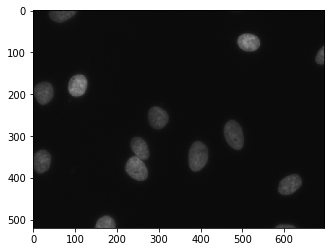

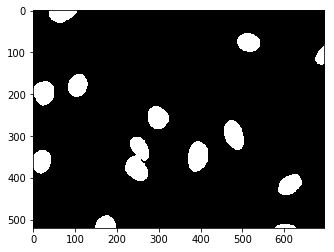

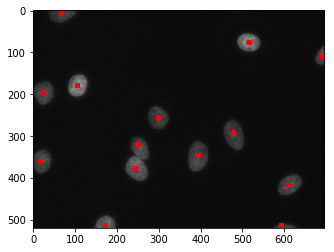

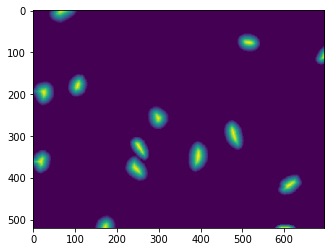

In [4]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids)-1)
plt.imshow(X_train[ix])
plt.show()
plt.imshow(np.squeeze(Y_train[ix][0]), cmap='gray')
plt.show()
x_copy = X_train[ix].copy()
x_copy[np.squeeze(Y_train[ix][1])>0, :] = 255, 0, 0
plt.imshow(x_copy)
plt.show()
plt.imshow(np.squeeze(Y_train[ix][2]))
plt.show()

Seems good!

# Create our Keras metric

Now we try to define the *mean average precision at different intersection over union (IoU) thresholds* metric in Keras. TensorFlow has a mean IoU metric, but it doesn't have any native support for the mean over multiple thresholds, so I tried to implement this. **I'm by no means certain that this implementation is correct, though!** Any assistance in verifying this would be most welcome! 

*Update: This implementation is most definitely not correct due to the very large discrepancy between the results reported here and the LB results. It also seems to just increase over time no matter what when you train ... *

In [5]:
from keras.losses import mean_squared_error
# Define IoU metric
def mean_iou(y_true_, y_pred_):
    y_true = y_true_[...,0]
    y_pred = y_pred_[...,0]
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=None) # scaler

def mean_iou_marker(y_true_, y_pred_):
    y_true = y_true_[...,1]
    y_pred = y_pred_[...,1]
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=None) # scaler

def custom_loss(y_true_, y_pred_):
    
    def dice_coef(y_true, y_pred, intersection): # (batch_size, h, w)
        return (2 * K.sum(intersection) + 1) / (K.sum(y_true) + K.sum(y_pred) + 1) # scaler
    
    obj_scale = 5
    noobj_scale = 0.5
    
    y_true_hm = y_true_[...,0] # (batch_size, h, w)
    y_true_mk = y_true_[...,1] # (batch_size, h, w)
    y_true_dt = y_true_[...,2] # (batch_size, h, w)
    
    y_pred_hm = y_pred_[...,0] # (batch_size, h, w)
    y_pred_mk = y_pred_[...,1] # (batch_size, h, w)
    y_pred_dt = y_pred_[...,2] # (batch_size, h, w)
    
    true_mask_scale = y_true_hm * (obj_scale-noobj_scale) + noobj_scale
    s_dt_regression_loss = K.sum(K.abs(y_true_dt - y_pred_dt) * true_mask_scale, axis=None) / K.sum(true_mask_scale, axis=None) # scaler
    
    intersection_scale_hm =  (1 - y_true_dt) * y_true_hm + 1
    intersection_scale_mk =  intersection_scale_hm + y_true_mk # U want higher recall?
    
    mk_intersection = y_true_mk * y_pred_mk
    hm_intersection = y_true_hm * y_pred_hm
    
    s_marker_dice_coef = dice_coef(y_true_mk * intersection_scale_mk, y_pred_mk * intersection_scale_mk, mk_intersection * intersection_scale_mk) # scaler
    s_heatmap_dice_coef= dice_coef(y_true_hm * intersection_scale_hm, y_pred_hm * intersection_scale_hm, hm_intersection * intersection_scale_hm) # scaler
    s_marker_entropy   = K.sum(K.binary_crossentropy(y_true_mk, y_pred_mk) * intersection_scale_mk, axis=None) / K.sum(intersection_scale_mk, axis=None) # scaler
    s_heatmap_entropy  = K.sum(K.binary_crossentropy(y_true_hm, y_pred_hm) * intersection_scale_hm, axis=None) / K.sum(intersection_scale_hm, axis=None) # scaler
    s_marker_loss = .5 * s_marker_entropy - s_marker_dice_coef + 1. # scaler [0, inf)
    s_heatmap_loss= .5 * s_heatmap_entropy - s_heatmap_dice_coef + 1. # scaler [0, inf)
    
    loss = 3 * s_marker_loss + s_heatmap_loss + 0.5 * s_dt_regression_loss # scaler [0, inf)
    loss = tf.Print(loss, [s_marker_dice_coef], message='\nMarker DC:\t', summarize=10)
    loss = tf.Print(loss, [s_marker_entropy], message='\nMarker ET:\t', summarize=10)
    loss = tf.Print(loss, [s_heatmap_dice_coef], message='\nHeatmap DC:\t', summarize=10)
    loss = tf.Print(loss, [s_heatmap_entropy], message='\nHeatmap ET:\t', summarize=10)
    loss = tf.Print(loss, [s_dt_regression_loss], message='\nDT MAE:\t', summarize=10)
    
    return loss # scaler [0, inf)

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [6]:
from keras.layers import Lambda, Add, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import Adam

def build_stage(inputs, last=None, id_='st1'):
    def conv(f, k=3, act='elu'):
        return Conv2D(f, (k, k), activation=act, kernel_initializer='he_normal', padding='same')
    def _incept_conv(inputs, f, chs=[0.1, 0.6, 0.2, 0.1]):
        fs = [] # determine channel number
        for k in chs:
            t = max(int(k*f), 1) # at least 1 channel
            fs.append(t)
        
        fs[1] += f-np.sum(fs) # reminding channels allocate to 3x3 conv
        
        c1x1 = conv(fs[0], 1, act='linear') (inputs)
        c3x3 = conv(max(1, fs[1]//2), 1, act='elu') (inputs)
        c5x5 = conv(max(1, fs[2]//2), 1, act='elu') (inputs)
        cpool= MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same') (inputs)
        
        c3x3 = conv(fs[1], 3, act='linear') (c3x3)
        c5x5 = conv(fs[2], 5, act='linear') (c5x5)
        cpool= conv(fs[3], 1, act='linear') (cpool)
        
        output = concatenate([c1x1, c3x3, c5x5, cpool], axis=-1)
        return output
    
    def _res_conv(inputs, f, k=3): # very simple residual module
        channels = int(inputs.shape[-1])
        
        cs = _incept_conv(inputs, f)
        
        if f!=channels:
            t1 = conv(f, 1, 'linear') (inputs) # identity mapping
        else:
            t1 = inputs
        
        out = Add()([t1, cs]) # t1 + c2
        out = BatchNormalization() (out)
        out = Activation('elu') (out)
        return out
    def pool():
        return MaxPooling2D((2, 2))
    def up(inputs):
        upsampled = Conv2DTranspose(int(inputs.shape[-1]), (2, 2), strides=(2, 2), padding='same') (inputs)
        return upsampled
    
    if last is None:
        c1 = Lambda(lambda x: x / 255) (inputs) # 1st stage input, an image
    else:
        c1 = concatenate()([inputs, last])
    
    c1 = _res_conv(c1, 32, 3)
    c1 = _res_conv(c1, 32, 3)
    o1 = c1
    p1 = pool() (c1)
    
    c2 = _res_conv(p1, 64, 3)
    c2 = _res_conv(c2, 64, 3)
    p2 = pool() (c2)

    c3 = _res_conv(p2, 128, 3)
    c3 = _res_conv(c3, 128, 3)
    p3 = pool() (c3)
    
    c4 = _res_conv(p3, 256, 3)
    c4 = _res_conv(c4, 256, 3)
    p4 = pool() (c4)
    
    c5 = _res_conv(p4, 512, 3)
    c5 = _res_conv(c5, 512, 3)
    p5 = pool() (c5)
    
    c6 = _res_conv(p5, 540, 3)
    c6 = _res_conv(c6, 540, 3)
    
    u7 = up (c6)
    c7 = concatenate([u7, c5])
    c7 = _res_conv(c7, 512, 3)
    c7 = _res_conv(c7, 512, 3)
    
    u8 = up (c7)
    c8 = concatenate([u8, c4])
    c8 = _res_conv(c8, 256, 3)
    c8 = _res_conv(c8, 256, 3)
    
    u9 = up (c8)
    c9 = concatenate([u9, c3])
    c9 = _res_conv(c9, 128, 3)
    c9 = _res_conv(c9, 128, 3)
    
    u10 = up (c9)
    c10 = concatenate([u10, c2])
    c10 = _res_conv(c10, 64, 3)
    c10 = _res_conv(c10, 64, 3)
    
    u11 = up (c10)
    c11 = concatenate([u11, c1])
    c11 = _res_conv(c11, 32, 3)
    c11 = _res_conv(c11, 32, 3)
    
    c12 = Conv2D(3, (1, 1)) (c11)
    b12 = BatchNormalization() (c12)
    a12 = Activation('sigmoid') (b12)
    return a12, o1

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
out, _ = build_stage(inputs, None, 'st1')

model = Model(inputs=[inputs], outputs=[out])
model.compile(loss=custom_loss, metrics=[mean_iou, mean_iou_marker], optimizer='adam')
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 10) 40          lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 3)  12          lambda_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [7]:
from keras.utils import Sequence
import cv2
from sklearn.utils import shuffle
from skimage.transform import AffineTransform, warp
import copy

class data_generator(Sequence):
    def __init__(self, data, label, batch_size=4, training=True):
        self.data = data
        self.label= label
        self.batch_size = batch_size
        self.training = training
    def __len__(self):
        return int(np.ceil(float(len(self.data))/self.batch_size))
    def on_epoch_end(self):
        if self.training: self.data, self.label = shuffle(self.data, self.label)
    def __getitem__(self, i):
        l_bound =  i    * self.batch_size
        r_bound = (i+1) * self.batch_size
        if r_bound>len(self.data): # ensure every iteration has the same batch size
            r_bound = len(self.data)
            l_bound = r_bound - self.batch_size
        dat_que = np.empty((self.batch_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
        lab_que = np.empty((self.batch_size, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
        for n, index in enumerate(range(l_bound, r_bound)):
            img = copy.deepcopy(self.data[index]).astype(np.float32) / 255.
            lab = copy.deepcopy(self.label[index][0])
            marker = copy.deepcopy(self.label[index][1])
            dt = copy.deepcopy(self.label[index][2])
            if self.training:
                if np.random.rand() < .5: # flip vertical
                    img = np.flip(img, 0)
                    lab = np.flip(lab, 0)
                    marker = np.flip(marker, 0)
                    dt = np.flip(dt, 0)
                if np.random.rand() < .5: # flip horizontal
                    img = np.flip(img, 1)
                    lab = np.flip(lab, 1)
                    marker = np.flip(marker, 1)
                    dt = np.flip(dt, 1)

                # rotation, shearing
                if np.random.rand() < 0.5:
                    y, x, _ = img.shape
                    h, w = y, x
                    img = np.pad(img, ((y//2, y//2), (x//2, x//2), (0, 0)), 'reflect')
                    lab = np.pad(lab, ((y//2, y//2), (x//2, x//2)), 'reflect')
                    marker = np.pad(marker, ((y//2, y//2), (x//2, x//2)), 'reflect')
                    dt = np.pad(dt, ((y//2, y//2), (x//2, x//2)), 'reflect')
                    
                    rotT = np.random.uniform(-50,50)
                    shearT = np.random.uniform(-8,8)
                    translationX = np.random.uniform(-w,w) * .05
                    translationY = np.random.uniform(-h,h) * .05
                    atmtx = AffineTransform(rotation=rotT, shear=shearT, translation=(translationX, translationY))

                    img = warp(img, atmtx)
                    lab = warp(lab, atmtx)
                    marker = warp(marker, atmtx)
                    dt = warp(dt, atmtx)

                    img = img[h//2:h//2+h,w//2:w//2+w,:]
                    lab = lab[h//2:h//2+h,w//2:w//2+w]
                    marker = marker[h//2:h//2+h,w//2:w//2+w]
                    dt = dt[h//2:h//2+h,w//2:w//2+w]

                # random amplify each channel
                a = .1 # amptitude
                t  = [np.random.uniform(-a,a)]
                t += [np.random.uniform(-a,a)]
                t += [np.random.uniform(-a,a)]
                t = np.array(t)

                img = np.clip(img * (1. + t), 0, 1) # channel wise amplify
                up = np.random.uniform(0.95, 1.05) # change gamma
                img = np.clip(img**up, 0, 1) # apply gamma and convert back to range [0,255]

            ### end of data augmentation ###

            img = (resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)*255.).astype(np.uint8)
            lab = resize(lab, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            marker = resize(marker, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            dt = resize(dt, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

            dat_que[n,:,:,:] = img
            lab_que[n,:,:,0] = lab > .5
            lab_que[n,:,:,1] = marker > .5
            lab_que[n,:,:,2] = dt
        return dat_que, lab_que

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=65, shuffle=True)

In [9]:
if not os.path.exists('./models'):
    os.makedirs('./models')

BS=8
EPOCHS=1000
train_generator = data_generator(X_train, Y_train, batch_size=BS, training=True)
val_generator = data_generator(X_val, Y_val, batch_size=BS, training=False)

# earlystopper = EarlyStopping(patience=7, verbose=1)
checkpointer = ModelCheckpoint('./models/model.{epoch:03d}.vl.{val_loss:.2f}.vi.{val_mean_iou:.2f}.vim.{val_mean_iou_marker:.2f}.h5', verbose=0, save_best_only=False)
checkpointer_best = ModelCheckpoint('./models/best.h5', verbose=1, save_best_only=True)
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator), epochs=EPOCHS, 
                              validation_data=val_generator, 
                              validation_steps=len(val_generator),
                              callbacks=[checkpointer, checkpointer_best],
                              workers=5,
                              use_multiprocessing=True
                              )

Epoch 1/400
76/76 [==============================] - 81s 1s/step - loss: 5.0106 - mean_iou: 0.6074 - mean_iou_marker: 0.4694 - val_loss: 5.5190 - val_mean_iou: 0.6776 - val_mean_iou_marker: 0.5010

Epoch 00001: val_loss improved from inf to 5.51902, saving model to ./models/best.h5
Epoch 2/400
76/76 [==============================] - 71s 932ms/step - loss: 4.9035 - mean_iou: 0.6960 - mean_iou_marker: 0.5060 - val_loss: 4.6228 - val_mean_iou: 0.7087 - val_mean_iou_marker: 0.5200

Epoch 00002: val_loss improved from 5.51902 to 4.62277, saving model to ./models/best.h5
Epoch 3/400
76/76 [==============================] - 71s 935ms/step - loss: 4.7387 - mean_iou: 0.7205 - mean_iou_marker: 0.5312 - val_loss: 4.3890 - val_mean_iou: 0.7322 - val_mean_iou_marker: 0.5410

Epoch 00003: val_loss improved from 4.62277 to 4.38896, saving model to ./models/best.h5
Epoch 4/400
76/76 [==============================] - 71s 939ms/step - loss: 4.6388 - mean_iou: 0.7414 - mean_iou_marker: 0.5483 - val_los

76/76 [==============================] - 71s 938ms/step - loss: 2.9795 - mean_iou: 0.8550 - mean_iou_marker: 0.6513 - val_loss: 2.6210 - val_mean_iou: 0.8557 - val_mean_iou_marker: 0.6519

Epoch 00030: val_loss improved from 2.69682 to 2.62102, saving model to ./models/best.h5
Epoch 31/400
76/76 [==============================] - 71s 936ms/step - loss: 2.8534 - mean_iou: 0.8563 - mean_iou_marker: 0.6525 - val_loss: 2.5554 - val_mean_iou: 0.8570 - val_mean_iou_marker: 0.6533

Epoch 00031: val_loss improved from 2.62102 to 2.55542, saving model to ./models/best.h5
Epoch 32/400
76/76 [==============================] - 71s 939ms/step - loss: 2.9123 - mean_iou: 0.8577 - mean_iou_marker: 0.6539 - val_loss: 2.5584 - val_mean_iou: 0.8582 - val_mean_iou_marker: 0.6544

Epoch 00032: val_loss did not improve
Epoch 33/400
76/76 [==============================] - 71s 940ms/step - loss: 2.7622 - mean_iou: 0.8588 - mean_iou_marker: 0.6550 - val_loss: 2.4924 - val_mean_iou: 0.8594 - val_mean_iou_marke


Epoch 00059: val_loss improved from 1.60880 to 1.56542, saving model to ./models/best.h5
Epoch 60/400
76/76 [==============================] - 72s 950ms/step - loss: 1.8274 - mean_iou: 0.8777 - mean_iou_marker: 0.6793 - val_loss: 1.6384 - val_mean_iou: 0.8779 - val_mean_iou_marker: 0.6797

Epoch 00060: val_loss did not improve
Epoch 61/400
76/76 [==============================] - 72s 948ms/step - loss: 1.6855 - mean_iou: 0.8782 - mean_iou_marker: 0.6801 - val_loss: 1.6074 - val_mean_iou: 0.8784 - val_mean_iou_marker: 0.6805

Epoch 00061: val_loss did not improve
Epoch 62/400
76/76 [==============================] - 72s 948ms/step - loss: 1.7190 - mean_iou: 0.8785 - mean_iou_marker: 0.6808 - val_loss: 1.5242 - val_mean_iou: 0.8787 - val_mean_iou_marker: 0.6812

Epoch 00062: val_loss improved from 1.56542 to 1.52423, saving model to ./models/best.h5
Epoch 63/400
76/76 [==============================] - 72s 946ms/step - loss: 1.7078 - mean_iou: 0.8789 - mean_iou_marker: 0.6815 - val_loss

76/76 [==============================] - 74s 972ms/step - loss: 1.2511 - mean_iou: 0.8881 - mean_iou_marker: 0.6974 - val_loss: 1.2401 - val_mean_iou: 0.8882 - val_mean_iou_marker: 0.6976

Epoch 00091: val_loss did not improve
Epoch 92/400
76/76 [==============================] - 74s 976ms/step - loss: 1.3573 - mean_iou: 0.8883 - mean_iou_marker: 0.6978 - val_loss: 1.2790 - val_mean_iou: 0.8885 - val_mean_iou_marker: 0.6979

Epoch 00092: val_loss did not improve
Epoch 93/400
76/76 [==============================] - 74s 976ms/step - loss: 1.3644 - mean_iou: 0.8886 - mean_iou_marker: 0.6981 - val_loss: 1.2569 - val_mean_iou: 0.8887 - val_mean_iou_marker: 0.6983

Epoch 00093: val_loss did not improve
Epoch 94/400
76/76 [==============================] - 74s 967ms/step - loss: 1.3101 - mean_iou: 0.8888 - mean_iou_marker: 0.6984 - val_loss: 1.2365 - val_mean_iou: 0.8889 - val_mean_iou_marker: 0.6986

Epoch 00094: val_loss did not improve
Epoch 95/400
76/76 [==============================] -

76/76 [==============================] - 72s 945ms/step - loss: 1.0809 - mean_iou: 0.8942 - mean_iou_marker: 0.7096 - val_loss: 1.1278 - val_mean_iou: 0.8942 - val_mean_iou_marker: 0.7098

Epoch 00123: val_loss improved from 1.14086 to 1.12776, saving model to ./models/best.h5
Epoch 124/400
76/76 [==============================] - 72s 942ms/step - loss: 1.0451 - mean_iou: 0.8943 - mean_iou_marker: 0.7100 - val_loss: 1.1522 - val_mean_iou: 0.8944 - val_mean_iou_marker: 0.7101

Epoch 00124: val_loss did not improve
Epoch 125/400
76/76 [==============================] - 72s 942ms/step - loss: 1.0768 - mean_iou: 0.8945 - mean_iou_marker: 0.7103 - val_loss: 1.1414 - val_mean_iou: 0.8945 - val_mean_iou_marker: 0.7105

Epoch 00125: val_loss did not improve
Epoch 126/400
76/76 [==============================] - 73s 959ms/step - loss: 1.0869 - mean_iou: 0.8946 - mean_iou_marker: 0.7106 - val_loss: 1.1513 - val_mean_iou: 0.8947 - val_mean_iou_marker: 0.7108

Epoch 00126: val_loss did not improve

Epoch 156/400
76/76 [==============================] - 72s 950ms/step - loss: 1.0390 - mean_iou: 0.8982 - mean_iou_marker: 0.7183 - val_loss: 1.1456 - val_mean_iou: 0.8982 - val_mean_iou_marker: 0.7184

Epoch 00156: val_loss did not improve
Epoch 157/400
76/76 [==============================] - 72s 952ms/step - loss: 1.0248 - mean_iou: 0.8983 - mean_iou_marker: 0.7185 - val_loss: 1.1356 - val_mean_iou: 0.8983 - val_mean_iou_marker: 0.7187

Epoch 00157: val_loss did not improve
Epoch 158/400
76/76 [==============================] - 72s 950ms/step - loss: 1.0101 - mean_iou: 0.8984 - mean_iou_marker: 0.7188 - val_loss: 1.1029 - val_mean_iou: 0.8984 - val_mean_iou_marker: 0.7189

Epoch 00158: val_loss did not improve
Epoch 159/400
76/76 [==============================] - 72s 950ms/step - loss: 1.0498 - mean_iou: 0.8985 - mean_iou_marker: 0.7190 - val_loss: 1.1175 - val_mean_iou: 0.8985 - val_mean_iou_marker: 0.7191

Epoch 00159: val_loss did not improve
Epoch 160/400
76/76 [===============

76/76 [==============================] - 74s 968ms/step - loss: 1.0051 - mean_iou: 0.9009 - mean_iou_marker: 0.7253 - val_loss: 1.1620 - val_mean_iou: 0.9010 - val_mean_iou_marker: 0.7254

Epoch 00189: val_loss did not improve
Epoch 190/400
76/76 [==============================] - 74s 974ms/step - loss: 0.9281 - mean_iou: 0.9010 - mean_iou_marker: 0.7255 - val_loss: 1.0798 - val_mean_iou: 0.9010 - val_mean_iou_marker: 0.7256

Epoch 00190: val_loss did not improve
Epoch 191/400
76/76 [==============================] - 74s 974ms/step - loss: 0.9812 - mean_iou: 0.9011 - mean_iou_marker: 0.7257 - val_loss: 1.1079 - val_mean_iou: 0.9011 - val_mean_iou_marker: 0.7259

Epoch 00191: val_loss did not improve
Epoch 192/400
76/76 [==============================] - 74s 973ms/step - loss: 1.0403 - mean_iou: 0.9011 - mean_iou_marker: 0.7259 - val_loss: 1.1211 - val_mean_iou: 0.9012 - val_mean_iou_marker: 0.7260

Epoch 00192: val_loss did not improve
Epoch 193/400
76/76 [=============================

76/76 [==============================] - 71s 939ms/step - loss: 0.8948 - mean_iou: 0.9032 - mean_iou_marker: 0.7310 - val_loss: 1.1170 - val_mean_iou: 0.9033 - val_mean_iou_marker: 0.7311

Epoch 00223: val_loss did not improve
Epoch 224/400
76/76 [==============================] - 73s 958ms/step - loss: 0.8797 - mean_iou: 0.9033 - mean_iou_marker: 0.7312 - val_loss: 1.0975 - val_mean_iou: 0.9033 - val_mean_iou_marker: 0.7313

Epoch 00224: val_loss did not improve
Epoch 225/400
76/76 [==============================] - 76s 996ms/step - loss: 0.8982 - mean_iou: 0.9034 - mean_iou_marker: 0.7314 - val_loss: 1.1100 - val_mean_iou: 0.9034 - val_mean_iou_marker: 0.7315

Epoch 00225: val_loss did not improve
Epoch 226/400
76/76 [==============================] - 74s 976ms/step - loss: 0.9343 - mean_iou: 0.9034 - mean_iou_marker: 0.7315 - val_loss: 1.1181 - val_mean_iou: 0.9035 - val_mean_iou_marker: 0.7316

Epoch 00226: val_loss did not improve
Epoch 227/400
76/76 [=============================

76/76 [==============================] - 71s 938ms/step - loss: 0.8878 - mean_iou: 0.9050 - mean_iou_marker: 0.7359 - val_loss: 1.1174 - val_mean_iou: 0.9050 - val_mean_iou_marker: 0.7360

Epoch 00257: val_loss did not improve
Epoch 258/400
76/76 [==============================] - 73s 956ms/step - loss: 0.9648 - mean_iou: 0.9051 - mean_iou_marker: 0.7361 - val_loss: 1.1179 - val_mean_iou: 0.9051 - val_mean_iou_marker: 0.7361

Epoch 00258: val_loss did not improve
Epoch 259/400
76/76 [==============================] - 72s 943ms/step - loss: 0.9134 - mean_iou: 0.9051 - mean_iou_marker: 0.7362 - val_loss: 1.1017 - val_mean_iou: 0.9051 - val_mean_iou_marker: 0.7363

Epoch 00259: val_loss did not improve
Epoch 260/400
76/76 [==============================] - 72s 941ms/step - loss: 0.9222 - mean_iou: 0.9052 - mean_iou_marker: 0.7363 - val_loss: 1.1157 - val_mean_iou: 0.9052 - val_mean_iou_marker: 0.7364

Epoch 00260: val_loss did not improve
Epoch 261/400
76/76 [=============================

76/76 [==============================] - 73s 957ms/step - loss: 1.0734 - mean_iou: 0.9065 - mean_iou_marker: 0.7402 - val_loss: 1.1235 - val_mean_iou: 0.9065 - val_mean_iou_marker: 0.7402

Epoch 00291: val_loss did not improve
Epoch 292/400
76/76 [==============================] - 73s 956ms/step - loss: 0.9972 - mean_iou: 0.9065 - mean_iou_marker: 0.7403 - val_loss: 1.1117 - val_mean_iou: 0.9065 - val_mean_iou_marker: 0.7403

Epoch 00292: val_loss did not improve
Epoch 293/400
76/76 [==============================] - 73s 957ms/step - loss: 0.9535 - mean_iou: 0.9065 - mean_iou_marker: 0.7404 - val_loss: 1.1213 - val_mean_iou: 0.9065 - val_mean_iou_marker: 0.7404

Epoch 00293: val_loss did not improve
Epoch 294/400
76/76 [==============================] - 73s 956ms/step - loss: 0.8889 - mean_iou: 0.9066 - mean_iou_marker: 0.7405 - val_loss: 1.0822 - val_mean_iou: 0.9066 - val_mean_iou_marker: 0.7406

Epoch 00294: val_loss did not improve
Epoch 295/400
76/76 [=============================

76/76 [==============================] - 73s 966ms/step - loss: 0.9464 - mean_iou: 0.9077 - mean_iou_marker: 0.7437 - val_loss: 1.1176 - val_mean_iou: 0.9077 - val_mean_iou_marker: 0.7438

Epoch 00325: val_loss did not improve
Epoch 326/400
76/76 [==============================] - 73s 955ms/step - loss: 0.9307 - mean_iou: 0.9077 - mean_iou_marker: 0.7438 - val_loss: 1.0883 - val_mean_iou: 0.9077 - val_mean_iou_marker: 0.7439

Epoch 00326: val_loss did not improve
Epoch 327/400
76/76 [==============================] - 73s 963ms/step - loss: 0.8771 - mean_iou: 0.9078 - mean_iou_marker: 0.7439 - val_loss: 1.1024 - val_mean_iou: 0.9078 - val_mean_iou_marker: 0.7440

Epoch 00327: val_loss did not improve
Epoch 328/400
76/76 [==============================] - 74s 970ms/step - loss: 0.9135 - mean_iou: 0.9078 - mean_iou_marker: 0.7440 - val_loss: 1.1050 - val_mean_iou: 0.9078 - val_mean_iou_marker: 0.7441

Epoch 00328: val_loss did not improve
Epoch 329/400
76/76 [=============================

76/76 [==============================] - 72s 942ms/step - loss: 0.8859 - mean_iou: 0.9087 - mean_iou_marker: 0.7467 - val_loss: 1.1065 - val_mean_iou: 0.9088 - val_mean_iou_marker: 0.7468

Epoch 00359: val_loss did not improve
Epoch 360/400
76/76 [==============================] - 71s 937ms/step - loss: 0.8330 - mean_iou: 0.9088 - mean_iou_marker: 0.7468 - val_loss: 1.1093 - val_mean_iou: 0.9088 - val_mean_iou_marker: 0.7469

Epoch 00360: val_loss did not improve
Epoch 361/400
76/76 [==============================] - 71s 935ms/step - loss: 0.9144 - mean_iou: 0.9088 - mean_iou_marker: 0.7469 - val_loss: 1.1031 - val_mean_iou: 0.9088 - val_mean_iou_marker: 0.7470

Epoch 00361: val_loss did not improve
Epoch 362/400
76/76 [==============================] - 71s 934ms/step - loss: 0.8670 - mean_iou: 0.9088 - mean_iou_marker: 0.7470 - val_loss: 1.0971 - val_mean_iou: 0.9088 - val_mean_iou_marker: 0.7471

Epoch 00362: val_loss did not improve
Epoch 363/400
76/76 [=============================

76/76 [==============================] - 71s 939ms/step - loss: 0.8662 - mean_iou: 0.9096 - mean_iou_marker: 0.7495 - val_loss: 1.1256 - val_mean_iou: 0.9096 - val_mean_iou_marker: 0.7495

Epoch 00393: val_loss did not improve
Epoch 394/400
76/76 [==============================] - 71s 939ms/step - loss: 0.8590 - mean_iou: 0.9096 - mean_iou_marker: 0.7496 - val_loss: 1.1068 - val_mean_iou: 0.9096 - val_mean_iou_marker: 0.7496

Epoch 00394: val_loss did not improve
Epoch 395/400
76/76 [==============================] - 71s 935ms/step - loss: 0.8588 - mean_iou: 0.9096 - mean_iou_marker: 0.7497 - val_loss: 1.1291 - val_mean_iou: 0.9096 - val_mean_iou_marker: 0.7497

Epoch 00395: val_loss did not improve
Epoch 396/400
76/76 [==============================] - 71s 935ms/step - loss: 0.9158 - mean_iou: 0.9096 - mean_iou_marker: 0.7498 - val_loss: 1.1009 - val_mean_iou: 0.9097 - val_mean_iou_marker: 0.7498

Epoch 00396: val_loss did not improve
Epoch 397/400
76/76 [=============================

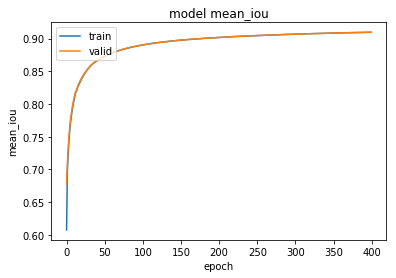

In [10]:
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('model mean_iou')
plt.ylabel('mean_iou')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

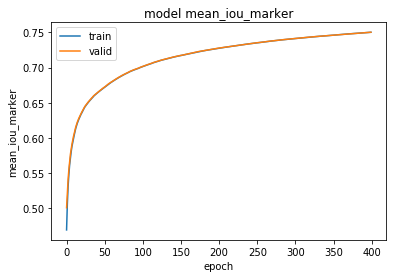

In [11]:
plt.plot(history.history['mean_iou_marker'])
plt.plot(history.history['val_mean_iou_marker'])
plt.title('model mean_iou_marker')
plt.ylabel('mean_iou_marker')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

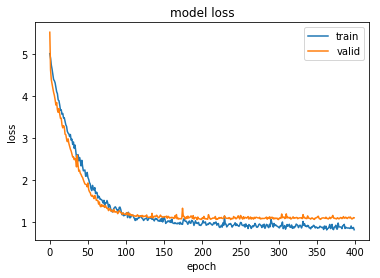

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper right')
plt.show()

All right, looks good! Loss seems to be a bit erratic, though. I'll leave it to you to improve the model architecture and parameters! 

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [13]:
from skimage.morphology import closing, square, remove_small_objects
from skimage.segmentation import clear_border

train_generator = data_generator(X_train, Y_train, batch_size=BS, training=False)
val_generator = data_generator(X_val, Y_val, batch_size=BS, training=False)

# Predict on train, val and test
model = load_model('./models/model.400.vl.1.11.vi.0.91.vim.0.75.h5', custom_objects={'mean_iou': mean_iou, 'custom_loss': custom_loss, 'mean_iou_marker': mean_iou_marker})

preds_train = model.predict_generator(train_generator, steps=len(train_generator), verbose=1)
preds_val = model.predict_generator(val_generator, steps=len(val_generator), verbose=1)
preds_test = model.predict(X_test, verbose=1, batch_size=BS)

preds_train, preds_train_marker, preds_train_dt = np.transpose(preds_train, (3,0,1,2))
preds_val, preds_val_marker, preds_val_dt = np.transpose(preds_val, (3,0,1,2))
preds_test, preds_test_marker, preds_test_dt = np.transpose(preds_test, (3,0,1,2))

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_train_marker_t = (preds_train_marker > 0.5).astype(np.uint8)
preds_val_marker_t = (preds_val_marker > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append((resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True),
                                 resize(np.squeeze(preds_test_marker[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True),
                                 resize(np.squeeze(preds_test_dt[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True)
                                ))

65/65 [==============================] - 2s 31ms/step


In [14]:
from skimage.morphology import watershed

# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def lb(image, marker, distance):
    if np.sum(image) < np.sum(marker):
        image = marker
    else:
        marker = np.array((marker==1) & (image==1))
    # distance = ndi.distance_transform_edt(image) # old one
    markers = ndi.label(marker)[0]
    labels = watershed(-distance, markers, mask=image)
    if np.sum(labels) == 0:
        labels[0,0] = 1
    return labels

def prob_to_rles(x, marker, dt, cutoff=0.5, cutoff_marker=0.5):
    lab_img = lb(x > cutoff, marker > cutoff_marker, dt)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

52


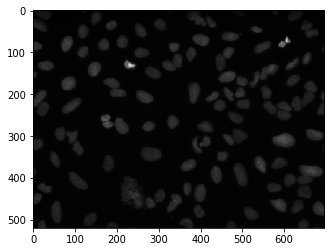

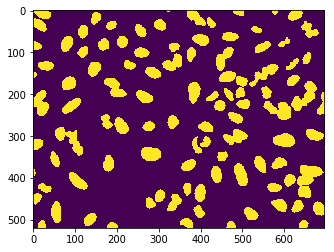

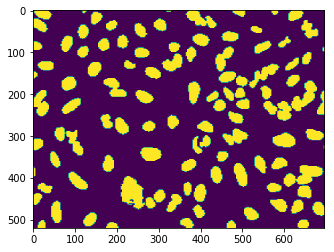

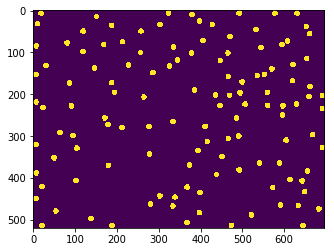

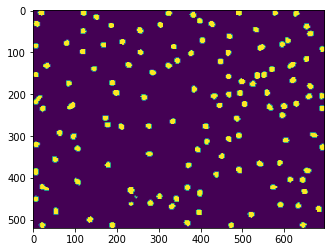

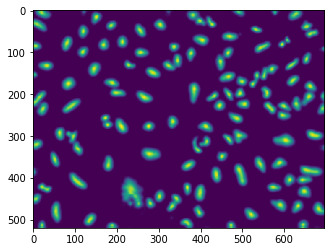

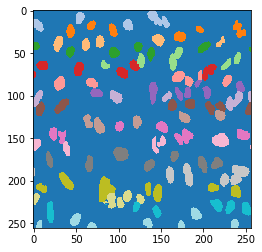

In [15]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t)-1)
print(ix)
shape = Y_train[ix][0].shape[:2]
plt.imshow(X_train[ix])
plt.show()
plt.imshow(np.squeeze(Y_train[ix][0]))
plt.show()
plt.imshow(resize(np.squeeze(preds_train_t[ix]), shape))
plt.show()
plt.imshow(np.squeeze(Y_train[ix][1]))
plt.show()
plt.imshow(resize(np.squeeze(preds_train_marker_t[ix]), shape))
plt.show()
plt.imshow(resize(np.squeeze(preds_train_dt[ix]), shape))
plt.show()
lab = lb(preds_train_t[ix], preds_train_marker_t[ix], preds_train_dt[ix])
plt.imshow(lab, cmap=plt.get_cmap('tab20'))
plt.show()

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

43


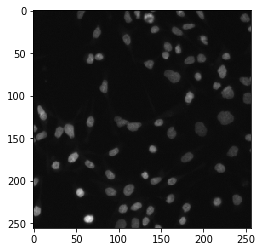

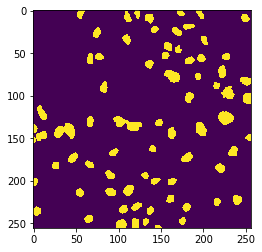

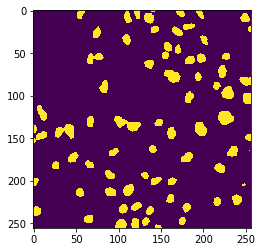

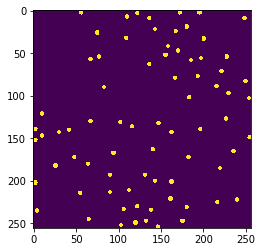

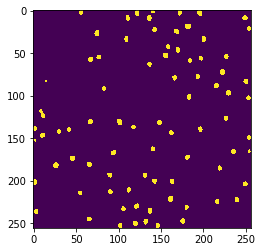

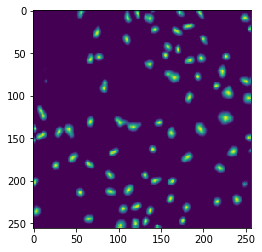

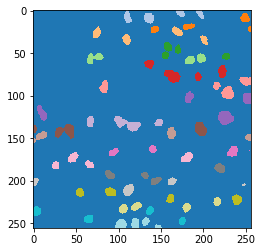

In [17]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t)-1)
print(ix)
shape = Y_val[ix][0].shape[:2]
plt.imshow(X_val[ix])
plt.show()
plt.imshow(np.squeeze(Y_val[ix][0]))
plt.show()
plt.imshow(resize(np.squeeze(preds_val_t[ix]), shape))
plt.show()
plt.imshow(np.squeeze(Y_val[ix][1]))
plt.show()
plt.imshow(resize(np.squeeze(preds_val_marker_t[ix]), shape))
plt.show()
plt.imshow(resize(np.squeeze(preds_val_dt[ix]), shape))
plt.show()
lab = lb(preds_val_t[ix], preds_val_marker_t[ix], preds_val_dt[ix])
plt.imshow(lab, cmap=plt.get_cmap('tab20'))
plt.show()

Not too shabby! Definitely needs some more training and tweaking.

# Encode and submit our results

Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [18]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(*preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

... and then finally create our submission!

In [19]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)

This scored 0.233 on the LB for me. That was with version 2 of this notebook; be aware that the results from the neural network are extremely erratic and vary greatly from run to run (version 3 is significantly worse, for example). Version 7 scores 0.277!

You should easily be able to stabilize and improve the results just by changing a few parameters, tweaking the architecture a little bit and training longer with early stopping.

**Have fun!**

LB score history:
- Version 7: 0.277 LB